In [1]:
# import modules

import os.path
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import random
from pathlib import Path
from tqdm import tqdm
from time import perf_counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score
from sklearn.metrics import confusion_matrix
from IPython.display import Markdown, display
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import shap
from lime import lime_image
from skimage.segmentation import mark_boundaries
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from tensorflow.keras.applications.vgg16 import preprocess_input


In [2]:
# 데이터 불러오기
data_dir = Path('/Users/belli/Desktop/youn/marburg/XAI/Practical Project/places/image')
filepaths = list(data_dir.glob(r'**/*.jpg'))
def proc_img(filepath):
    """
    이미지 데이터의 경로와 label 데이터로 데이터프레임 만들기
    """
    valid_filepaths = [f for f in filepath if f.parent.name]  # 상위 폴더가 있는 경로만 필터링

    labels = [f.parent.name for f in valid_filepaths]  # Path 객체에서 상위 폴더 이름 추출

    filepath = pd.Series([str(f) for f in valid_filepaths], name='Filepath')
    labels = pd.Series(labels, name='Label')

    # 경로와 라벨 concatenate
    df = pd.concat([filepath, labels], axis=1)

    # index 재설정
    df = df.sample(frac=1, random_state=0).reset_index(drop=True)

    return df

df = proc_img(filepaths)
df.head(5)

Filepath   Label
0  \Users\belli\Desktop\youn\marburg\XAI\Practica...  nature
1  \Users\belli\Desktop\youn\marburg\XAI\Practica...   urban
2  \Users\belli\Desktop\youn\marburg\XAI\Practica...   urban
3  \Users\belli\Desktop\youn\marburg\XAI\Practica...   urban
4  \Users\belli\Desktop\youn\marburg\XAI\Practica...  nature

In [3]:
print(f'Number of pictures: {df.shape[0]}\n')
print(f'Number of different labels: {len(df.Label.unique())}\n')
print(f'Labels: {df.Label.unique()}')

Number of pictures: 5000

Number of different labels: 2

Labels: ['nature' 'urban']


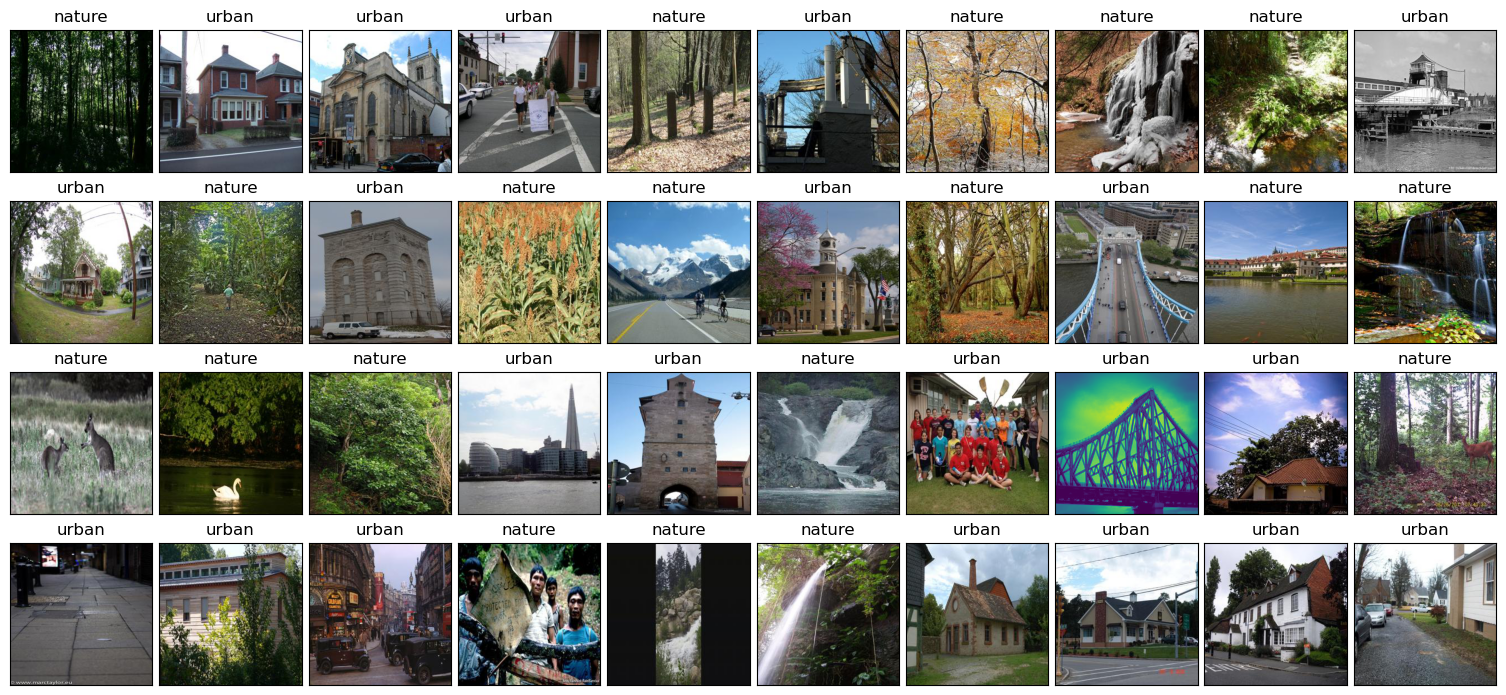

In [4]:
# 이미지 데이터 확인

fig, axes = plt.subplots(nrows=4, ncols=10, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df.Filepath[i]))
    ax.set_title(df.Label[i], fontsize = 12)
plt.tight_layout(pad=0.5)
plt.show()

In [5]:
# 이미지 전처리

# Training/test split
# train_df,test_df = train_test_split(df.sample(frac=0.2), test_size=0.1,random_state=0) #모델링 시간이 오래걸리면 사용
train_df,test_df = train_test_split(df, test_size=0.1,random_state=0)
train_df.shape,test_df.shape

((4500, 2), (500, 2))

In [6]:
# 베이스라인 모델 설정

# 모델 전처리
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split=0.2)

train_gen = train_datagen.flow_from_directory('/Users/belli/Desktop/youn/marburg/XAI/Practical Project/places/image',
                                                 target_size = (150, 150),
                                                 batch_size = 32,
                                                 class_mode = 'categorical',subset='training')
val_gen  = train_datagen.flow_from_directory('/Users/belli/Desktop/youn/marburg/XAI/Practical Project/places/image',
                                                 target_size = (150, 150),
                                                 batch_size = 32,
                                                 class_mode = 'categorical',subset='validation')

# 딥러닝 CNN 모델로 베이스라인 모델링
# Initialising the CNN
cnn = tf.keras.models.Sequential()

# Step 1 - Convolution
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=[150, 150, 3]))

# Step 2 - Pooling
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

# Adding convolutional layer
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

# Step 3 - Flattening
cnn.add(tf.keras.layers.Flatten())

# Step 4 - Full Connection
cnn.add(tf.keras.layers.Dense(units=128, activation='relu'))

# Step 5 - Output Layer
cnn.add(tf.keras.layers.Dense(units=2, activation='softmax'))

# Compiling the CNN
cnn.compile(optimizer = 'adam', 
            loss = 'categorical_crossentropy', 
            metrics = ['accuracy'])
cnn.summary()

Found 4000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


C:\Users\belli\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 41472)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       5,308,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,318,946 (20.29 MB)

 Trainable params: 5,318,946 (20.29 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# 모델 성능 확인
cnn.fit(x = train_gen, validation_data = val_gen, epochs = 10)

C:\Users\belli\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 24s 174ms/step - accuracy: 0.5291 - loss: 1.0272 - val_accuracy: 0.7410 - val_loss: 0.5337
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 15s 120ms/step - accuracy: 0.6924 - loss: 0.5641 - val_accuracy: 0.7790 - val_loss: 0.4541
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 15s 117ms/step - accuracy: 0.7962 - loss: 0.4491 - val_accuracy: 0.7650 - val_loss: 0.4752
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 15s 116ms/step - accuracy: 0.8426 - loss: 0.3558 - val_accuracy: 0.7760 - val_loss: 0.4685
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 15s 117ms/step - accuracy: 0.9202 - loss: 0.2152 - val_accuracy: 0.7720 - val_loss: 0.5002
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 15s 116ms/step - accuracy: 0.9714 - loss: 0.1090 - val_accuracy: 0.7810 - val_loss: 0.6145
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 15s 117ms/step - accuracy: 0.9905 - loss: 0.0530 - val_accuracy: 0.7670 - val_loss: 0.6874
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 15s 116ms/step - accuracy: 0.9942 - loss: 0

In [8]:
# 모델 튜닝 후 성능 높이기

# 데이터 증강
def create_gen():
    # 생성기 및 데이터 증강으로 이미지 로드
    train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
        validation_split=0.1
    )

    test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
    )

    train_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath', # 파일위치 열이름
        y_col='Label', # 클래스 열이름
        target_size=(224, 224), # 이미지 사이즈
        color_mode='rgb', # 이미지 채널수
        class_mode='categorical', # Y값(Label값)
        batch_size=32,
        shuffle=True, # 데이터를 섞을지 여부
        seed=0,
        subset='training', # train 인지 val인지 설정
        rotation_range=30, # 회전제한 각도 30도
        zoom_range=0.15, # 확대 축소 15%
        width_shift_range=0.2, # 좌우이동 20%
        height_shift_range=0.2, # 상하이동 20%
        shear_range=0.15, # 반시계방햐의 각도
        horizontal_flip=True, # 좌우 반전 True
        fill_mode="nearest"
        # 이미지 변경시 보완 방법 (constant, nearest, reflect, wrap) 4개 존재
    )

    val_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='validation',
        rotation_range=30,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest"
    )

    test_images = test_generator.flow_from_dataframe(
        dataframe=test_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=False
    )
    
    return train_generator,test_generator,train_images,val_images,test_images

In [9]:
# 전이 학습

models = {
    "DenseNet121": {"model":tf.keras.applications.DenseNet121, "perf":0},
    "MobileNetV2": {"model":tf.keras.applications.MobileNetV2, "perf":0},
    "DenseNet201": {"model":tf.keras.applications.DenseNet201, "perf":0},
    "EfficientNetB0": {"model":tf.keras.applications.EfficientNetB0, "perf":0},
    "EfficientNetB1": {"model":tf.keras.applications.EfficientNetB1, "perf":0},
    "InceptionV3": {"model":tf.keras.applications.InceptionV3, "perf":0},
    "MobileNetV2": {"model":tf.keras.applications.MobileNetV2, "perf":0},
    "MobileNetV3Large": {"model":tf.keras.applications.MobileNetV3Large, "perf":0},
    "ResNet152V2": {"model":tf.keras.applications.ResNet152V2, "perf":0},
    "ResNet50": {"model":tf.keras.applications.ResNet50, "perf":0},
    "ResNet50V2": {"model":tf.keras.applications.ResNet50V2, "perf":0},
    "VGG19": {"model":tf.keras.applications.VGG19, "perf":0},
    "VGG16": {"model":tf.keras.applications.VGG16, "perf":0},
    "Xception": {"model":tf.keras.applications.Xception, "perf":0}
}
# Create the generators
train_generator,test_generator,train_images,val_images,test_images=create_gen()
print('\n')

def get_model(model):
# Load the pretained model
    kwargs =    {'input_shape':(224, 224, 3),
                'include_top':False,
                'weights':'imagenet',
                'pooling':'avg'}
    
    pretrained_model = model(**kwargs)
    pretrained_model.trainable = False # 레이어를 동결 시켜서 훈련중 손실을 최소화 한다.
    
    inputs = pretrained_model.input

    x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
    x = tf.keras.layers.Dense(128, activation='relu')(x)

    outputs = tf.keras.layers.Dense(2, activation='softmax')(x)
    # 라벨 개수가 2개이기 때문에 Dencs도 2로 설정
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Train모델 학습
for name, model in models.items():
    
    # 전이 학습 모델 가져오기
    m = get_model(model['model'])
    models[name]['model'] = m
    
    start = perf_counter()
    
    # 모델 학습
    history = m.fit(train_images,validation_data=val_images,epochs=1,verbose=0)
    
    # 학습시간과 val_accuracy 저장
    duration = perf_counter() - start
    duration = round(duration,2)
    models[name]['perf'] = duration
    print(f"{name:20} trained in {duration} sec")
    
    val_acc = history.history['val_accuracy']
    models[name]['val_acc'] = [round(v,4) for v in val_acc]

Found 4050 validated image filenames belonging to 2 classes.
Found 450 validated image filenames belonging to 2 classes.
Found 500 validated image filenames belonging to 2 classes.




C:\Users\belli\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


DenseNet121          trained in 129.57 sec
MobileNetV2          trained in 39.37 sec
DenseNet201          trained in 205.6 sec
EfficientNetB0       trained in 60.03 sec
EfficientNetB1       trained in 84.23 sec
InceptionV3          trained in 74.9 sec
MobileNetV3Large     trained in 35.4 sec
ResNet152V2          trained in 332.12 sec
ResNet50             trained in 173.11 sec
ResNet50V2           trained in 98.41 sec
VGG19                trained in 385.2 sec
VGG16                trained in 298.47 sec
Xception             trained in 127.96 sec


In [10]:
# 모델 성능 확인

# test데이터로 모델 성능 예측
for name, model in models.items():
    
    # Predict the label of the test_images
    pred = models[name]['model'].predict(test_images)
    pred = np.argmax(pred,axis=1)

    # Map the label
    labels = (train_images.class_indices)
    labels = dict((v,k) for k,v in labels.items())
    pred = [labels[k] for k in pred]

    y_test = list(test_df.Label)
    acc = accuracy_score(y_test,pred)
    models[name]['acc'] = round(acc,4)
    print(f'**{name} has a {acc * 100:.2f}% accuracy on the test set**')
   
# Create a DataFrame with the results
models_result = []

for name, v in models.items():
    models_result.append([ name, models[name]['val_acc'][-1], 
                          models[name]['acc'],
                          models[name]['perf']])
    
df_results = pd.DataFrame(models_result, 
                          columns = ['model','val_accuracy','accuracy','Training time (sec)'])
df_results.sort_values(by='accuracy', ascending=False, inplace=True)
df_results.reset_index(inplace=True,drop=True)
df_results

16/16 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step 
**DenseNet121 has a 95.80% accuracy on the test set**
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 309ms/step
**MobileNetV2 has a 96.00% accuracy on the test set**
16/16 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step
**DenseNet201 has a 96.20% accuracy on the test set**
16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 474ms/step
**EfficientNetB0 has a 53.40% accuracy on the test set**
16/16 ━━━━━━━━━━━━━━━━━━━━ 18s 851ms/step
**EfficientNetB1 has a 59.20% accuracy on the test set**
16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 642ms/step
**InceptionV3 has a 95.80% accuracy on the test set**
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 291ms/step
**MobileNetV3Large has a 77.60% accuracy on the test set**
16/16 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step
**ResNet152V2 has a 95.60% accuracy on the test set**
16/16 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step 
**ResNet50 has a 74.00% accuracy on the test set**
16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 741ms/step
**ResNet50V2 has a 96.60% accuracy on the test set**
16/16 ━━━━━━━━━━━━━━━━━━━━ 43s 3s/step
**VGG1

model  val_accuracy  accuracy  Training time (sec)
0         ResNet50V2        0.9600     0.966                98.41
1        DenseNet201        0.9556     0.962               205.60
2        MobileNetV2        0.9533     0.960                39.37
3        DenseNet121        0.9489     0.958               129.57
4        InceptionV3        0.9444     0.958                74.90
5        ResNet152V2        0.9444     0.956               332.12
6           Xception        0.9400     0.956               127.96
7              VGG16        0.9467     0.954               298.47
8              VGG19        0.9244     0.944               385.20
9   MobileNetV3Large        0.7511     0.776                35.40
10          ResNet50        0.7156     0.740               173.11
11    EfficientNetB1        0.5822     0.592                84.23
12    EfficientNetB0        0.4933     0.534                60.03

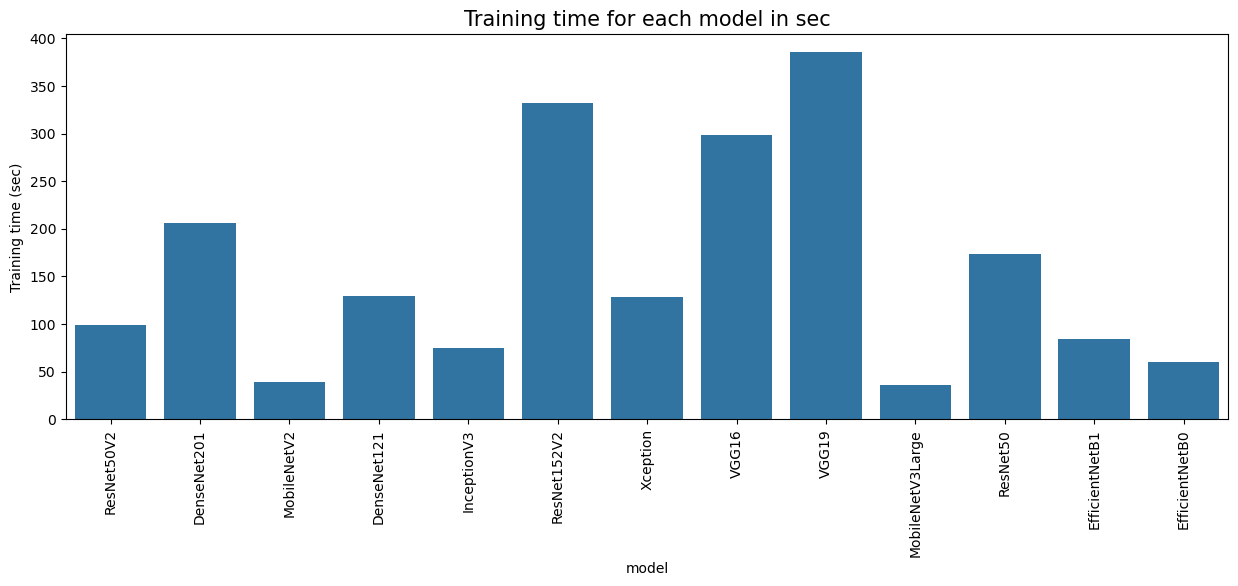

In [11]:
plt.figure(figsize = (15,5))
sns.barplot(x = 'model', y = 'Training time (sec)', data = df_results)
plt.title('Training time for each model in sec', fontsize = 15)
# plt.ylim(0,20)
plt.xticks(rotation=90)
plt.show()

Found 4050 validated image filenames belonging to 2 classes.
Found 450 validated image filenames belonging to 2 classes.
Found 500 validated image filenames belonging to 2 classes.
Epoch 1/7


C:\Users\belli\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


127/127 ━━━━━━━━━━━━━━━━━━━━ 211s 1s/step - accuracy: 0.8861 - loss: 0.2420 - val_accuracy: 0.9556 - val_loss: 0.1235
Epoch 2/7
127/127 ━━━━━━━━━━━━━━━━━━━━ 243s 2s/step - accuracy: 0.9679 - loss: 0.0954 - val_accuracy: 0.9622 - val_loss: 0.1122
Epoch 3/7
127/127 ━━━━━━━━━━━━━━━━━━━━ 189s 1s/step - accuracy: 0.9743 - loss: 0.0765 - val_accuracy: 0.9578 - val_loss: 0.1130
Epoch 4/7
127/127 ━━━━━━━━━━━━━━━━━━━━ 170s 1s/step - accuracy: 0.9788 - loss: 0.0621 - val_accuracy: 0.9511 - val_loss: 0.1238
Epoch 5/7
127/127 ━━━━━━━━━━━━━━━━━━━━ 162s 1s/step - accuracy: 0.9834 - loss: 0.0520 - val_accuracy: 0.9622 - val_loss: 0.1138
Epoch 6/7
127/127 ━━━━━━━━━━━━━━━━━━━━ 162s 1s/step - accuracy: 0.9864 - loss: 0.0418 - val_accuracy: 0.9600 - val_loss: 0.1295
Epoch 7/7
127/127 ━━━━━━━━━━━━━━━━━━━━ 168s 1s/step - accuracy: 0.9918 - loss: 0.0203 - val_accuracy: 0.9600 - val_loss: 0.1383


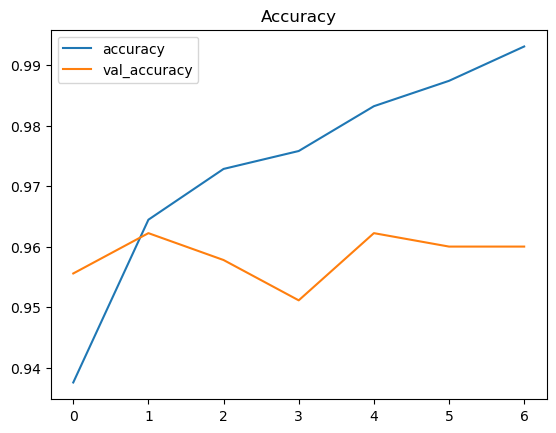

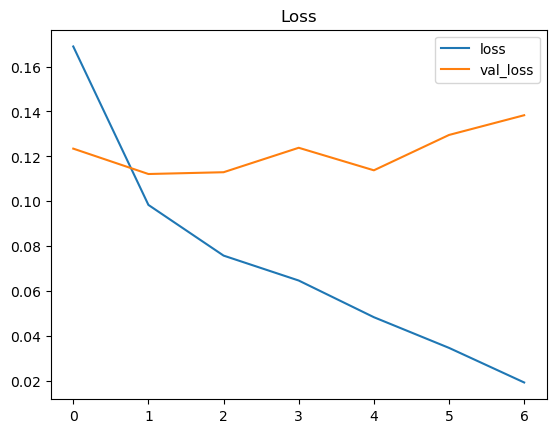

C:\Users\belli\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


16/16 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step
Accuracy on the test set: 96.00%


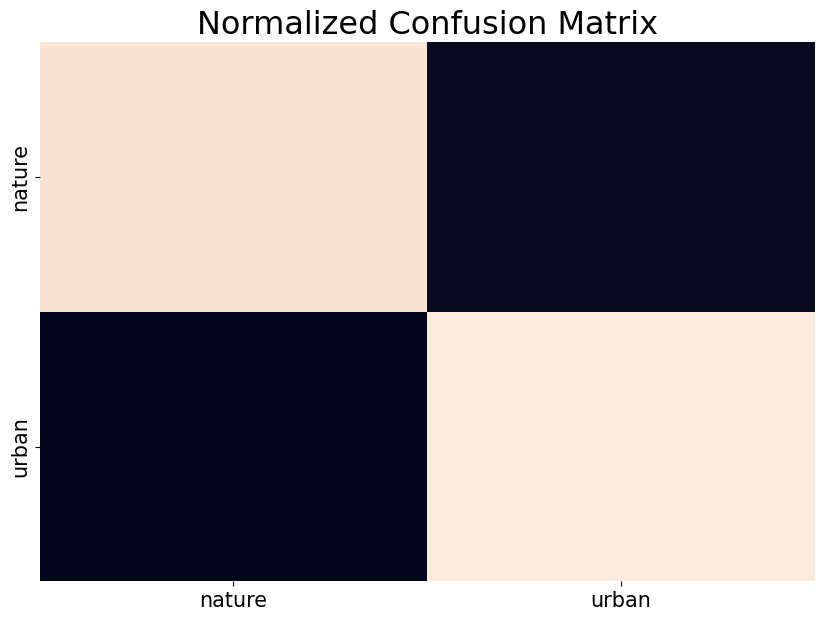

In [12]:
# 모델 성능 확인

train_df,test_df = train_test_split(df, test_size=0.1, random_state=0)
train_generator,test_generator,train_images,val_images,test_images=create_gen()

model = get_model(tf.keras.applications.DenseNet201)
history = model.fit(train_images,validation_data=val_images,epochs=7)

# Accuracy
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

# Loss
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

# Predict the label of the test_images
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]
    
y_test = list(test_df.Label)
acc = accuracy_score(y_test,pred)
print(f'Accuracy on the test set: {acc * 100:.2f}%')

# Confusion Matrix
cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (10,7))
sns.heatmap(cf_matrix, annot=False, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)),cbar=False)
plt.title('Normalized Confusion Matrix', fontsize = 23)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

----------------------------------------------------------------------------------

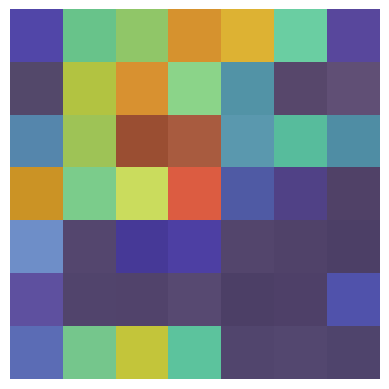

In [13]:
# Grad-CAM (1)
def grad_cam(model, img_array, layer_name, class_idx=None):
    """
    Grad-CAM을 계산하는 함수
    Args:
        model: 사전 학습된 모델
        img_array: 입력 이미지 배열 (4D 텐서 형태, (1, height, width, channels))
        layer_name: Grad-CAM을 계산할 레이어 이름
        class_idx: 관심 있는 클래스 인덱스 (None인 경우 모델의 출력 중 최대 값 사용)
    Returns:
        heatmap: Grad-CAM 결과 히트맵
    """
    # 모델의 출력과 해당 레이어의 출력 가져오기
    grad_model = tf.keras.models.Model(
        inputs=model.input,
        outputs=[model.get_layer(layer_name).output, model.output]
    )
    
    # Gradient를 계산하기 위해 tf.GradientTape 사용
    with tf.GradientTape() as tape:
        conv_output, predictions = grad_model(img_array)  # 레이어와 최종 출력
        if class_idx is None:
            class_idx = tf.argmax(predictions[0])  # 가장 높은 클래스 예측
        loss = predictions[:, class_idx]  # 특정 클래스의 예측값을 손실로 설정

    # 손실에 대한 레이어 출력의 Gradient 계산
    grads = tape.gradient(loss, conv_output)

    # 중요도를 계산: Global Average Pooling
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Conv 레이어 출력에 중요도를 곱함
    conv_output = conv_output[0]
    heatmap = conv_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # 히트맵 정규화
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# Grad-CAM 실행
def display_grad_cam(image_path, model, layer_name, class_idx=None):
    """
    Grad-CAM 결과를 시각화하는 함수
    """
    # 이미지 전처리 및 불러오기
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)

    # Grad-CAM 계산
    heatmap = grad_cam(model, img_array, layer_name, class_idx)

    # 히트맵 시각화
    plt.imshow(img)
    plt.imshow(heatmap, cmap='jet', alpha=0.5)  # 원본 이미지 위에 히트맵 오버레이
    plt.axis('off')
    plt.show()

# 예제 실행
display_grad_cam('/Users/belli/Desktop/youn/marburg/XAI/Practical Project/places/image/nature/field-wild-00000329.jpg', model, 'conv5_block16_concat')  # 레이어 이름은 모델에 따라 조정

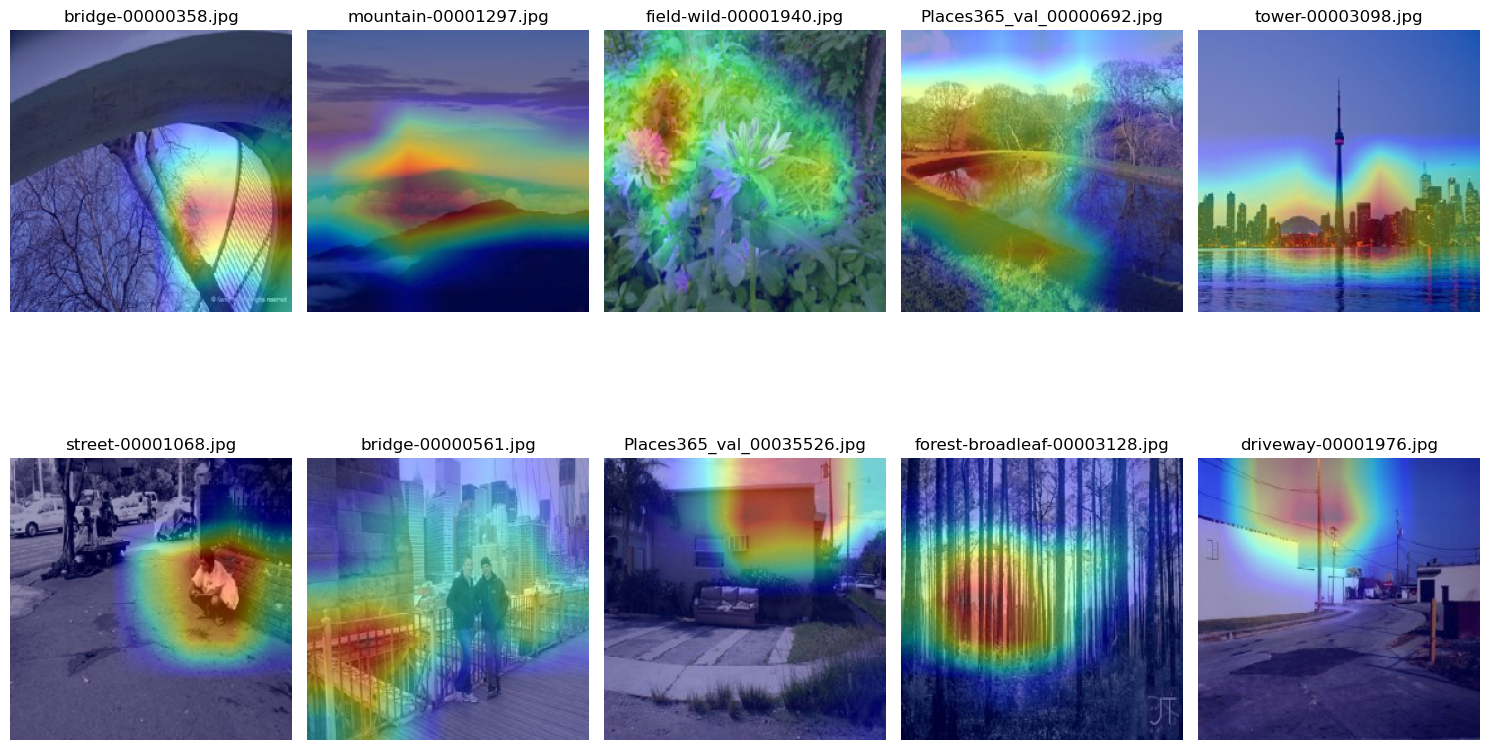

In [14]:
# Grad-CAM (2)
# 픽셀이 너무 커서 부드럽게 조정

def grad_cam(model, img_array, layer_name, class_idx=None):
    grad_model = tf.keras.models.Model(
        inputs=model.input,
        outputs=[model.get_layer(layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_output, predictions = grad_model(img_array)
        if class_idx is None:
            class_idx = tf.argmax(predictions[0])
        loss = predictions[:, class_idx]

    grads = tape.gradient(loss, conv_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_output = conv_output[0]
    heatmap = conv_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# Grad-CAM 시각화 함수
def display_grad_cam(image_path, model, layer_name, class_idx=None):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)

    heatmap = grad_cam(model, img_array, layer_name, class_idx)

    heatmap = tf.image.resize(heatmap[..., tf.newaxis], (224, 224)).numpy()
    heatmap = np.squeeze(heatmap)
    heatmap = np.clip(heatmap, 0, 1)

    original_img = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
    original_img = tf.keras.preprocessing.image.img_to_array(original_img).astype(np.uint8)

    colormap = plt.cm.jet(heatmap)[:, :, :3]
    colormap = np.uint8(255 * colormap)

    overlayed_img = 0.6 * original_img + 0.4 * colormap
    overlayed_img = np.uint8(overlayed_img)

    return overlayed_img

# 랜덤으로 이미지를 선택해 Grad-CAM 실행 및 시각화
def random_grad_cam(folder_path, model, layer_name, num_images=10):
    # nature 및 urban 폴더 탐색
    nature_path = os.path.join(folder_path, "nature")
    urban_path = os.path.join(folder_path, "urban")
    
    # 두 폴더에서 모든 이미지 파일 가져오기
    nature_images = [os.path.join(nature_path, img) for img in os.listdir(nature_path) if img.lower().endswith(('jpg', 'jpeg', 'png'))]
    urban_images = [os.path.join(urban_path, img) for img in os.listdir(urban_path) if img.lower().endswith(('jpg', 'jpeg', 'png'))]
    
    # 두 폴더에서 이미지를 합치고 랜덤 샘플링
    all_images = nature_images + urban_images
    selected_images = random.sample(all_images, min(len(all_images), num_images))
    
    # Grad-CAM 실행 및 시각화
    plt.figure(figsize=(15, 10))
    for i, image_path in enumerate(selected_images):
        overlayed_img = display_grad_cam(image_path, model, layer_name)
        plt.subplot(2, 5, i + 1)  # 2행 5열의 서브플롯
        plt.imshow(overlayed_img)
        plt.title(os.path.basename(image_path))  # 파일 이름 표시
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# 사전 학습된 모델과 레이어 이름
model = tf.keras.applications.MobileNetV2(weights="imagenet")
layer_name = "Conv_1_bn"

# 실행: 'image' 폴더 경로
folder_path = "/Users/belli/Desktop/youn/marburg/XAI/Practical Project/places/image"
random_grad_cam(folder_path, model, layer_name, num_images=10)


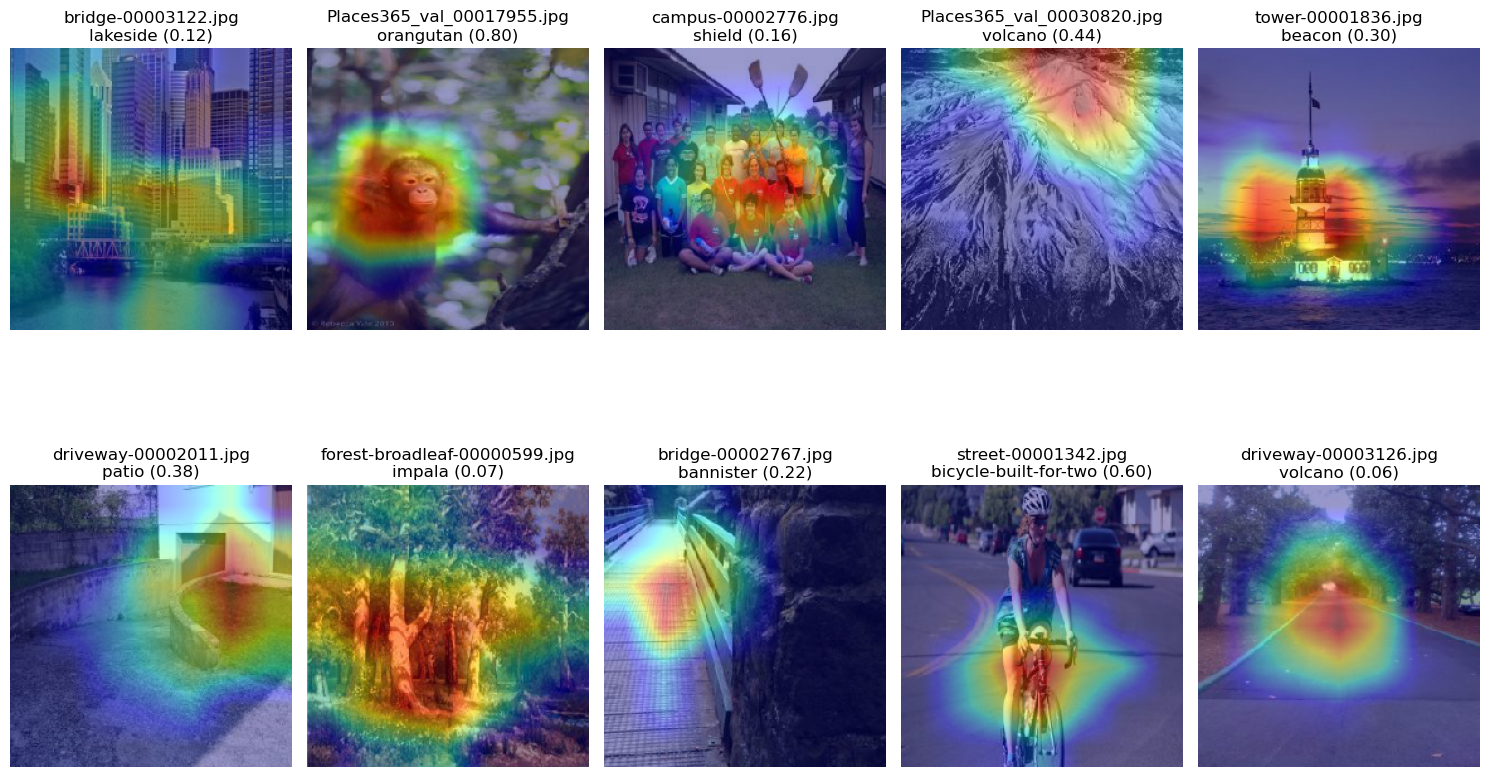

In [15]:
# Grad-CAM (3)
# 무엇으로 분류되었는지 보이기
def grad_cam(model, img_array, layer_name, class_idx=None):
    grad_model = tf.keras.models.Model(
        inputs=model.input,
        outputs=[model.get_layer(layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_output, predictions = grad_model(img_array)
        if class_idx is None:
            class_idx = tf.argmax(predictions[0])
        loss = predictions[:, class_idx]

    grads = tape.gradient(loss, conv_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_output = conv_output[0]
    heatmap = conv_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy(), predictions.numpy()

# Grad-CAM 시각화 함수
def display_grad_cam(image_path, model, layer_name):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)

    heatmap, predictions = grad_cam(model, img_array, layer_name)

    # 예측 결과 디코딩 (ImageNet 클래스)
    decoded_preds = tf.keras.applications.mobilenet_v2.decode_predictions(predictions, top=1)
    pred_label = decoded_preds[0][0][1]  # 클래스 이름
    pred_confidence = decoded_preds[0][0][2]  # 확률

    # Heatmap 크기 조정
    heatmap = tf.image.resize(heatmap[..., tf.newaxis], (224, 224)).numpy()
    heatmap = np.squeeze(heatmap)
    heatmap = np.clip(heatmap, 0, 1)

    # 원본 이미지 로드
    original_img = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
    original_img = tf.keras.preprocessing.image.img_to_array(original_img).astype(np.uint8)

    # 컬러맵 적용
    colormap = plt.cm.jet(heatmap)[:, :, :3]
    colormap = np.uint8(255 * colormap)

    # 원본 이미지와 컬러맵 오버레이
    overlayed_img = 0.6 * original_img + 0.4 * colormap
    overlayed_img = np.uint8(overlayed_img)

    return overlayed_img, pred_label, pred_confidence

# 랜덤으로 이미지를 선택해 Grad-CAM 실행 및 시각화
def random_grad_cam(folder_path, model, layer_name, num_images=10):
    # nature 및 urban 폴더 탐색
    nature_path = os.path.join(folder_path, "nature")
    urban_path = os.path.join(folder_path, "urban")
    
    # 두 폴더에서 모든 이미지 파일 가져오기
    nature_images = [os.path.join(nature_path, img) for img in os.listdir(nature_path) if img.lower().endswith(('jpg', 'jpeg', 'png'))]
    urban_images = [os.path.join(urban_path, img) for img in os.listdir(urban_path) if img.lower().endswith(('jpg', 'jpeg', 'png'))]
    
    # 두 폴더에서 이미지를 합치고 랜덤 샘플링
    all_images = nature_images + urban_images
    selected_images = random.sample(all_images, min(len(all_images), num_images))
    
    # Grad-CAM 실행 및 시각화
    plt.figure(figsize=(15, 10))
    for i, image_path in enumerate(selected_images):
        overlayed_img, pred_label, pred_confidence = display_grad_cam(image_path, model, layer_name)
        plt.subplot(2, 5, i + 1)  # 2행 5열의 서브플롯
        plt.imshow(overlayed_img)
        plt.title(f"{os.path.basename(image_path)}\n{pred_label} ({pred_confidence:.2f})")  # 파일 이름과 예측 결과
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# 사전 학습된 모델과 레이어 이름
model = tf.keras.applications.MobileNetV2(weights="imagenet")
layer_name = "Conv_1_bn"

# 실행: 'image' 폴더 경로
folder_path = "/Users/belli/Desktop/youn/marburg/XAI/Practical Project/places/image"
random_grad_cam(folder_path, model, layer_name, num_images=10)


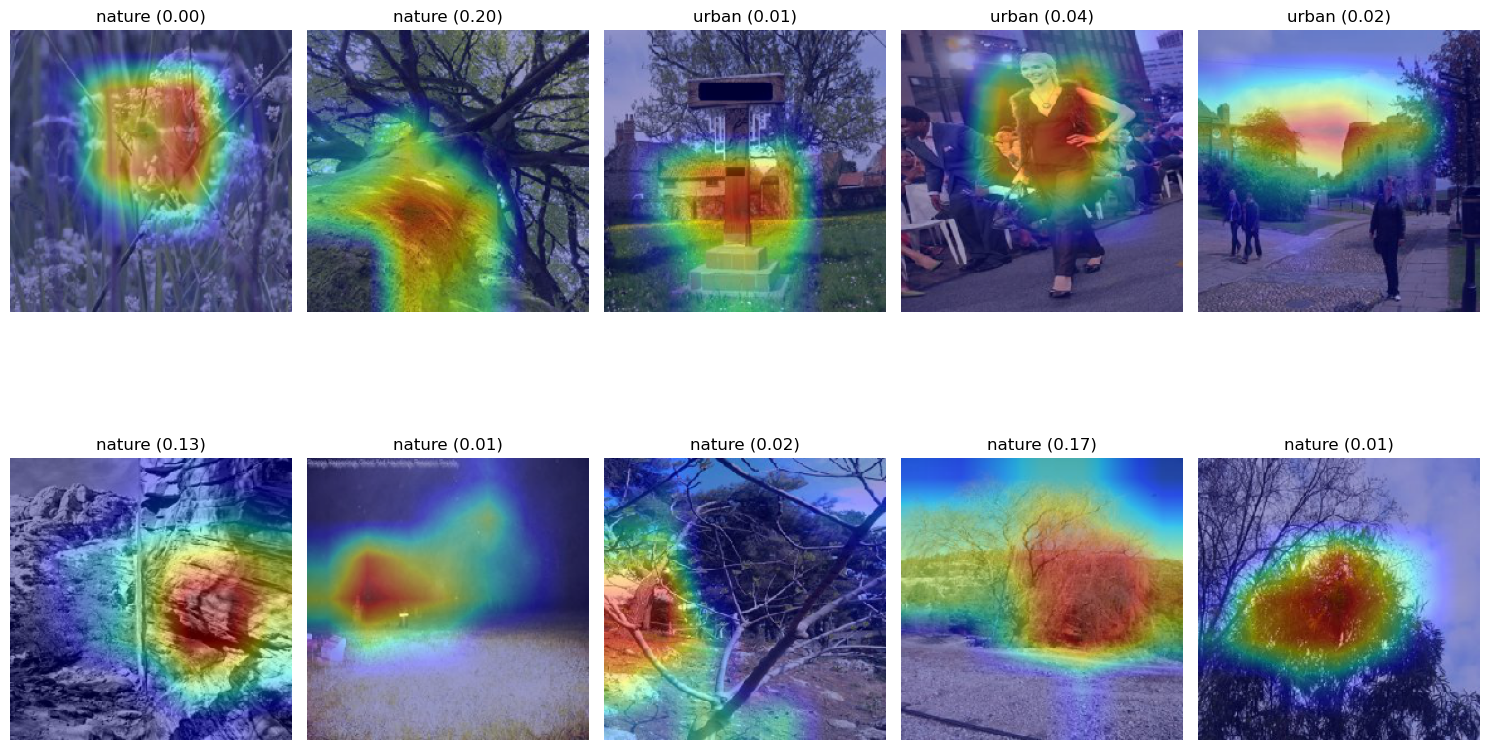

In [16]:
# Grad-CAM (4)
# urban / nature 이진분류
def grad_cam(model, img_array, layer_name, class_idx=None):
    grad_model = tf.keras.models.Model(
        inputs=model.input,
        outputs=[model.get_layer(layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_output, predictions = grad_model(img_array)
        if class_idx is None:
            class_idx = tf.argmax(predictions[0])
        loss = predictions[:, class_idx]

    grads = tape.gradient(loss, conv_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_output = conv_output[0]
    heatmap = conv_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy(), predictions.numpy()

# Grad-CAM 시각화 함수
def display_grad_cam(image_path, model, layer_name, urban_classes, nature_classes):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)

    heatmap, predictions = grad_cam(model, img_array, layer_name)

    # 예측 결과 디코딩 (ImageNet 클래스)
    decoded_preds = tf.keras.applications.mobilenet_v2.decode_predictions(predictions, top=5)
    pred_label = decoded_preds[0][0][1]  # 클래스 이름
    pred_confidence = decoded_preds[0][0][2]  # 확률

    # urban/nature 분류
    urban_score = sum(predictions[0, urban_classes])
    nature_score = sum(predictions[0, nature_classes])
    final_label = "urban" if urban_score > nature_score else "nature"
    final_confidence = max(urban_score, nature_score)

    # Heatmap 크기 조정
    heatmap = tf.image.resize(heatmap[..., tf.newaxis], (224, 224)).numpy()
    heatmap = np.squeeze(heatmap)
    heatmap = np.clip(heatmap, 0, 1)

    # 원본 이미지 로드
    original_img = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
    original_img = tf.keras.preprocessing.image.img_to_array(original_img).astype(np.uint8)

    # 컬러맵 적용
    colormap = plt.cm.jet(heatmap)[:, :, :3]
    colormap = np.uint8(255 * colormap)

    # 원본 이미지와 컬러맵 오버레이
    overlayed_img = 0.6 * original_img + 0.4 * colormap
    overlayed_img = np.uint8(overlayed_img)

    return overlayed_img, final_label, final_confidence

# 랜덤으로 이미지를 선택해 Grad-CAM 실행 및 시각화
def random_grad_cam(folder_path, model, layer_name, urban_classes, nature_classes, num_images=10):
    # nature 및 urban 폴더 탐색
    nature_path = os.path.join(folder_path, "nature")
    urban_path = os.path.join(folder_path, "urban")
    
    # 두 폴더에서 모든 이미지 파일 가져오기
    nature_images = [os.path.join(nature_path, img) for img in os.listdir(nature_path) if img.lower().endswith(('jpg', 'jpeg', 'png'))]
    urban_images = [os.path.join(urban_path, img) for img in os.listdir(urban_path) if img.lower().endswith(('jpg', 'jpeg', 'png'))]
    
    # 두 폴더에서 이미지를 합치고 랜덤 샘플링
    all_images = nature_images + urban_images
    selected_images = random.sample(all_images, min(len(all_images), num_images))
    
    # Grad-CAM 실행 및 시각화
    plt.figure(figsize=(15, 10))
    for i, image_path in enumerate(selected_images):
        overlayed_img, final_label, final_confidence = display_grad_cam(
            image_path, model, layer_name, urban_classes, nature_classes)
        plt.subplot(2, 5, i + 1)  # 2행 5열의 서브플롯
        plt.imshow(overlayed_img)
        plt.title(f"{final_label} ({final_confidence:.2f})")  # urban/nature 및 확률
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# 사전 학습된 모델과 레이어 이름
model = tf.keras.applications.MobileNetV2(weights="imagenet")
layer_name = "Conv_1_bn"

# urban/nature 클래스 매핑 (ImageNet 클래스 인덱스)
urban_classes = [555, 834, 835, 873]  # 예: dam, building 등
nature_classes = [970, 972, 976, 978]  # 예: valley, forest 등

# 실행: 'image' 폴더 경로
folder_path = "/Users/belli/Desktop/youn/marburg/XAI/Practical Project/places/image"
random_grad_cam(folder_path, model, layer_name, urban_classes, nature_classes, num_images=10)


Processing image 1: /Users/belli/Desktop/youn/marburg/XAI/Practical Project/places/image\nature\waterfall-00001531.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 587ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 773ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 700ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 758ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 729ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 753ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 815ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 793ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 743ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 855ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 747ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 761ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 773ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 756ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 765ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 780ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 768ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 778ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 779ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 753ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 790ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 758ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 832ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 784ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 800ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 

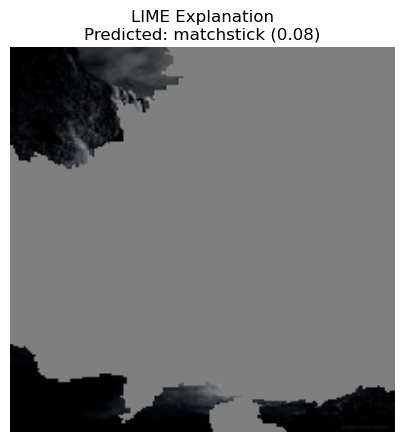

Processing image 2: /Users/belli/Desktop/youn/marburg/XAI/Practical Project/places/image\urban\tower-00002059.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 813ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 765ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 822ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 779ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 767ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 814ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 810ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 791ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 772ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 766ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 777ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 796ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 836ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 775ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 801ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 779ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 786ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 762ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 802ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 731ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 756ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 710ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 750ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 764ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 743ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

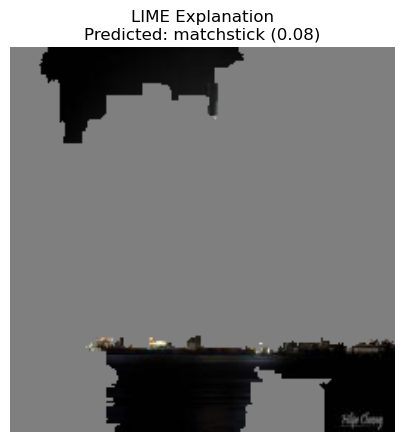

Processing image 3: /Users/belli/Desktop/youn/marburg/XAI/Practical Project/places/image\urban\campus-00003181.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 804ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 821ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 836ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 776ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 793ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 764ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 776ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 816ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 809ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 798ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 761ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 811ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 770ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 818ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 787ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 849ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 859ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 822ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 784ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 832ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 828ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 818ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 835ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 822ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 811ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

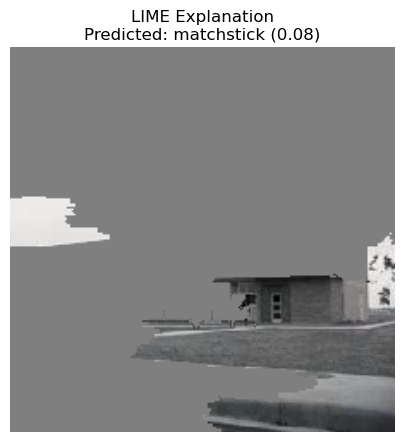

Processing image 4: /Users/belli/Desktop/youn/marburg/XAI/Practical Project/places/image\urban\street-00002689.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 802ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 861ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 820ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 797ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 775ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 807ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 824ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 814ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 784ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 804ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 799ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 818ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 820ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 804ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 835ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 786ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 832ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 823ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 776ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 807ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 841ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 795ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 828ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 819ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 830ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

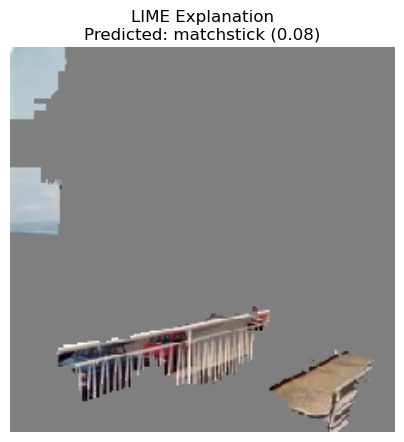

Processing image 5: /Users/belli/Desktop/youn/marburg/XAI/Practical Project/places/image\nature\waterfall-00001649.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 779ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 799ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 779ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 872ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 799ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 839ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 806ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 816ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 816ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 800ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 842ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 791ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 835ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 772ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 788ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 786ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 826ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 824ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 802ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 784ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 795ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 800ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 809ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 827ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 812ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

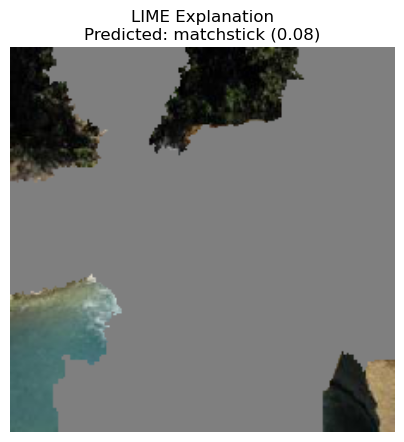

In [17]:
# LIME 기반 설명 함수
def explain_with_lime(model, img_path):
    """
    LIME을 사용하여 이미지에 대한 설명 생성 및 시각화
    Args:
        model: 사전 학습된 Keras 모델 (VGG16 등)
        img_path: 이미지 경로
    """
    # 이미지 로드 및 전처리
    img = load_img(img_path, target_size=(224, 224))
    img_array = img_to_array(img) / 255.0  # [0, 1] 범위로 스케일링
    img_array = preprocess_input(img_array)  # VGG16에 맞게 전처리
    img_array = np.expand_dims(img_array, axis=0)  # 배치 차원 추가

    # 모델 예측 수행
    preds = model.predict(img_array)
    decoded_preds = decode_predictions(preds, top=2)[0]  # 상위 2개의 예측 결과 디코딩
    pred_label = decoded_preds[0][1]  # 가장 높은 확률의 클래스 이름
    pred_confidence = decoded_preds[0][2]  # 해당 클래스의 확률

    # LIME 이미지 설명기 초기화
    explainer = lime_image.LimeImageExplainer()
    explanation = explainer.explain_instance(
        img_array[0],
        model.predict,
        top_labels=2,
        hide_color=0,  # 배경을 검은색으로 설정
        num_samples=1000
    )

    # 설명 결과 가져오기
    label = explanation.top_labels[0]  # 상위 레이블 선택
    temp, mask = explanation.get_image_and_mask(
        label=label,
        positive_only=False,  # 긍정/부정 영역 모두 표시
        hide_rest=False       # 배경 숨기지 않음
    )

    # 원본 이미지와 마스크 결합
    original_img = img_to_array(load_img(img_path, target_size=(224, 224))) / 255.0  # 원본 이미지를 [0, 1] 범위로
    mask = mask.astype(np.float32)  # 마스크를 float32로 변환
    mask = np.expand_dims(mask, axis=-1)  # 채널 차원 추가 (H, W) -> (H, W, 1)

    # 마스크와 원본 이미지를 결합 (강조 영역만 원본 이미지 표시)
    highlighted_img = mask * original_img + (1 - mask) * 0.5  # 배경은 50% 밝기 유지

    # 시각화
    plt.figure(figsize=(5, 5))  # 출력 이미지 크기 조정 (5x5 인치)
    plt.imshow(highlighted_img, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'LIME Explanation\nPredicted: {pred_label} ({pred_confidence:.2f})')
    plt.show()

# 랜덤 이미지 선택 및 실행 함수
def random_lime(folder_path, model, num_images=5):
    """
    주어진 폴더에서 랜덤으로 이미지를 선택해 LIME 결과를 실행
    Args:
        folder_path: 이미지 폴더 경로
        model: 사전 학습된 Keras 모델 (VGG16 등)
        num_images: 실행할 이미지 개수
    """
    nature_folder = os.path.join(folder_path, 'nature')
    urban_folder = os.path.join(folder_path, 'urban')

    # nature 및 urban 폴더에서 이미지 경로 수집
    nature_images = [os.path.join(nature_folder, img) for img in os.listdir(nature_folder) if img.endswith(('.jpg', '.png'))]
    urban_images = [os.path.join(urban_folder, img) for img in os.listdir(urban_folder) if img.endswith(('.jpg', '.png'))]

    # 두 폴더의 이미지를 합쳐서 랜덤 샘플링
    all_images = nature_images + urban_images
    selected_images = random.sample(all_images, min(len(all_images), num_images))

    # LIME 결과 실행 및 시각화
    for i, img_path in enumerate(selected_images):
        print(f"Processing image {i+1}: {img_path}")
        explain_with_lime(model, img_path)

# 1. 사전 학습된 모델 로드
model = VGG16(weights="imagenet")

# 2. 실행: 'image' 폴더 경로
folder_path = '/Users/belli/Desktop/youn/marburg/XAI/Practical Project/places/image'
random_lime(folder_path, model, num_images=5)


Processing image 1: /Users/belli/Desktop/youn/marburg/XAI/Practical Project/places/image\urban\house-00004320.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicted: unknown (Confidence: 0.00)
Raw Predictions: [('n03729826', 'matchstick', 0.0757095), ('n01930112', 'nematode', 0.04869334), ('n03666591', 'lighter', 0.030601628), ('n03196217', 'digital_clock', 0.02955261), ('n04286575', 'spotlight', 0.02383589)]


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 

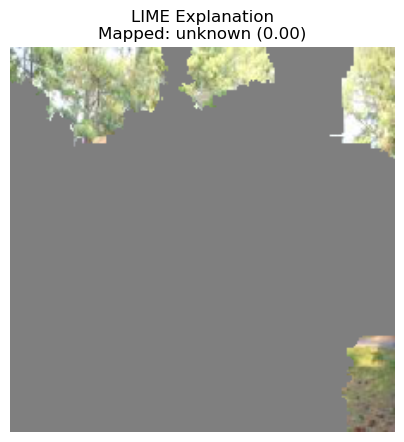

Processing image 2: /Users/belli/Desktop/youn/marburg/XAI/Practical Project/places/image\urban\house-00000173.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step
Predicted: unknown (Confidence: 0.00)
Raw Predictions: [('n03729826', 'matchstick', 0.07702326), ('n01930112', 'nematode', 0.04818864), ('n03666591', 'lighter', 0.031245762), ('n03196217', 'digital_clock', 0.03005207), ('n04286575', 'spotlight', 0.023871493)]


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 

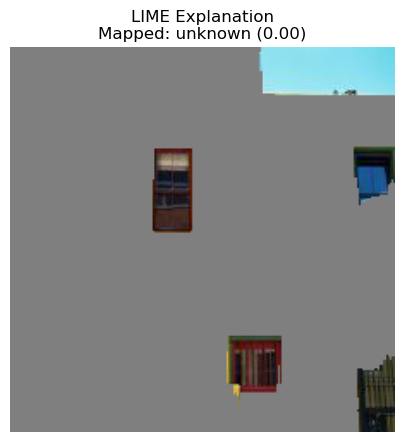

Processing image 3: /Users/belli/Desktop/youn/marburg/XAI/Practical Project/places/image\nature\rainforest-00003974.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step
Predicted: unknown (Confidence: 0.00)
Raw Predictions: [('n03729826', 'matchstick', 0.07638993), ('n01930112', 'nematode', 0.04795867), ('n03666591', 'lighter', 0.030924514), ('n03196217', 'digital_clock', 0.029598556), ('n04286575', 'spotlight', 0.024014842)]


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 

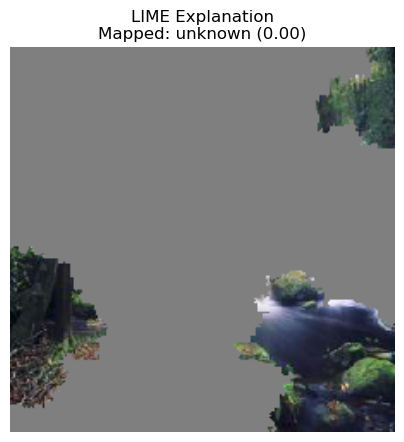

Processing image 4: /Users/belli/Desktop/youn/marburg/XAI/Practical Project/places/image\nature\Places365_val_00033147.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step
Predicted: unknown (Confidence: 0.00)
Raw Predictions: [('n03729826', 'matchstick', 0.07635529), ('n01930112', 'nematode', 0.047112495), ('n03666591', 'lighter', 0.030910049), ('n03196217', 'digital_clock', 0.029514275), ('n04286575', 'spotlight', 0.023770737)]


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 

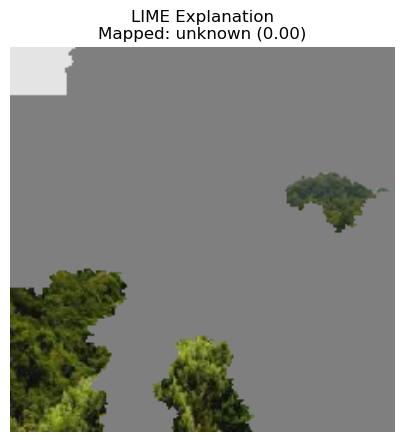

Processing image 5: /Users/belli/Desktop/youn/marburg/XAI/Practical Project/places/image\urban\house-00004631.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
Predicted: unknown (Confidence: 0.00)
Raw Predictions: [('n03729826', 'matchstick', 0.07515732), ('n01930112', 'nematode', 0.048565887), ('n03666591', 'lighter', 0.030677784), ('n03196217', 'digital_clock', 0.029904427), ('n04286575', 'spotlight', 0.023728415)]


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 812ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 795ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 798ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 848ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 789ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 770ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 809ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 740ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 755ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 772ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 751ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 769ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 780ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 779ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 757ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 761ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 782ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 732ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 754ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 764ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 758ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 741ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 792ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 798ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 801ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

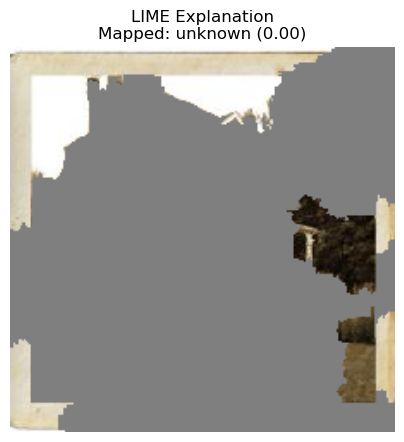

In [28]:


# ImageNet 레이블을 nature 및 urban으로 매핑
nature_labels = [
    "mountain", "valley", "volcano", "forest", "lakeside",
    "seashore", "ocean", "field", "desert", "park"
]
urban_labels = [
    "building", "street", "city", "castle", "tower",
    "skyscraper", "viaduct", "bridge", "palace", "stadium"
]

def map_to_custom_labels(decoded_preds):
    """
    ImageNet 예측 결과를 nature/urban으로 매핑
    """
    for pred in decoded_preds:
        label = pred[1].lower()  # 클래스 이름 소문자로 변환
        if label in nature_labels:
            return "nature", pred[2]  # nature, 확률 반환
        elif label in urban_labels:
            return "urban", pred[2]  # urban, 확률 반환
    return "unknown", 0.0  # 매핑되지 않으면 unknown 반환

def explain_with_lime(model, img_path):
    """
    LIME을 사용하여 이미지에 대한 설명 생성 및 시각화
    Args:
        model: 사전 학습된 Keras 모델 (VGG16 등)
        img_path: 이미지 경로
    """
    try:
        # 이미지 로드 및 전처리
        img = load_img(img_path, target_size=(224, 224))
        img_array = img_to_array(img) / 255.0  # [0, 1] 범위로 스케일링
        img_array = preprocess_input(img_array)  # VGG16에 맞게 전처리
        img_array = np.expand_dims(img_array, axis=0)  # 배치 차원 추가

        # 모델 예측 수행
        preds = model.predict(img_array)
        decoded_preds = decode_predictions(preds, top=5)[0]  # 상위 5개의 예측 결과 디코딩
        mapped_label, confidence = map_to_custom_labels(decoded_preds)  # 매핑 수행

        print(f"Predicted: {mapped_label} (Confidence: {confidence:.2f})")
        print(f"Raw Predictions: {decoded_preds}")

        # LIME 이미지 설명기 초기화
        explainer = lime_image.LimeImageExplainer()
        explanation = explainer.explain_instance(
            img_array[0],
            model.predict,
            top_labels=2,
            hide_color=0,  # 배경을 검은색으로 설정
            num_samples=1000
        )

        # 설명 결과 가져오기
        label = explanation.top_labels[0]  # 상위 레이블 선택
        temp, mask = explanation.get_image_and_mask(
            label=label,
            positive_only=False,  # 긍정/부정 영역 모두 표시
            hide_rest=False       # 배경 숨기지 않음
        )

        # 원본 이미지와 마스크 결합
        original_img = img_to_array(load_img(img_path, target_size=(224, 224))) / 255.0  # 원본 이미지를 [0, 1] 범위로
        mask = mask.astype(np.float32)  # 마스크를 float32로 변환
        mask = np.expand_dims(mask, axis=-1)  # 채널 차원 추가 (H, W) -> (H, W, 1)

        # 마스크와 원본 이미지를 결합 (강조 영역만 원본 이미지 표시)
        highlighted_img = mask * original_img + (1 - mask) * 0.5  # 배경은 50% 밝기 유지

        # 시각화
        plt.figure(figsize=(5, 5))  # 출력 이미지 크기 조정 (5x5 인치)
        plt.imshow(highlighted_img, interpolation='bilinear')
        plt.axis('off')
        plt.title(f'LIME Explanation\nMapped: {mapped_label} ({confidence:.2f})')
        plt.show()

    except Exception as e:
        print(f"Error processing image {img_path}: {e}")

def random_lime(folder_path, model, num_images=5):
    """
    주어진 폴더에서 랜덤으로 이미지를 선택해 LIME 결과를 실행
    Args:
        folder_path: 이미지 폴더 경로
        model: 사전 학습된 Keras 모델 (VGG16 등)
        num_images: 실행할 이미지 개수
    """
    nature_folder = os.path.join(folder_path, 'nature')
    urban_folder = os.path.join(folder_path, 'urban')

    # nature 및 urban 폴더에서 이미지 경로 수집
    nature_images = [os.path.join(nature_folder, img) for img in os.listdir(nature_folder) if img.endswith(('.jpg', '.png'))]
    urban_images = [os.path.join(urban_folder, img) for img in os.listdir(urban_folder) if img.endswith(('.jpg', '.png'))]

    # 두 폴더의 이미지를 합쳐서 랜덤 샘플링
    all_images = nature_images + urban_images

    if not all_images:
        print("No images found in the specified folders.")
        return

    selected_images = random.sample(all_images, min(len(all_images), num_images))

    # LIME 결과 실행 및 시각화
    for i, img_path in enumerate(selected_images):
        print(f"Processing image {i+1}: {img_path}")
        explain_with_lime(model, img_path)

# 1. 사전 학습된 모델 로드
model = VGG16(weights="imagenet")

# 2. 실행: 'image' 폴더 경로
folder_path = '/Users/belli/Desktop/youn/marburg/XAI/Practical Project/places/image'
random_lime(folder_path, model, num_images=5)
